In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import re
import glob
import math
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
import pyspark.pandas as ps
import pyspark.sql.functions as F
import statsmodels.formula.api as smf
from pyspark.sql.types import *
from datetime import datetime, timedelta
from collections import defaultdict
from multiprocessing import Manager

spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "7g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .appName('exploration') \
    .getOrCreate()
# spark.conf.set("spark.sql.session.timeZone", "America/New_York")


/Users/alanlu/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/documents/2024/MAST30034/proj2/project-2-group-buy-now-pay-later-industry-project-30/.venv/lib/python3.11/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(
24/09/12 00:47:35 WARN Utils: Your hostname, Alans-MacBook-Air-4.local resolves to a loopback address: 127.0.0.1; using 192.168.0.52 instead (on interface en0)
24/09/12 00:47:35 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/12 00:47:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platfo

In [10]:
transactions1 = spark.read.parquet("../data/transactions/transactions_20210228_20210827_snapshot")
transactions2 = spark.read.parquet("../data/transactions/transactions_20210828_20220227_snapshot")
transactions3 = spark.read.parquet("../data/transactions/transactions_20220228_20220828_snapshot")

transactions = transactions1.union(transactions2).union(transactions3)
transactions.show(truncate=False)
transactions.summary().show(truncate=False)

+-------+------------+------------------+------------------------------------+--------------+
|user_id|merchant_abn|dollar_value      |order_id                            |order_datetime|
+-------+------------+------------------+------------------------------------+--------------+
|18478  |62191208634 |63.255848959735246|949a63c8-29f7-4ab0-ada4-99ac50a88952|2021-08-20    |
|2      |15549624934 |130.3505283105634 |6a84c3cf-612a-4574-835b-144a47353eff|2021-08-20    |
|18479  |64403598239 |120.15860593212783|b10dcc33-e53f-4254-863c-de5266810cbc|2021-08-20    |
|3      |60956456424 |136.6785200286976 |0f09c5a5-784e-4477-b049-8ee4dd069b7b|2021-08-20    |
|18479  |94493496784 |72.96316578355305 |f6c78c1a-4600-4c5f-8e97-6e9eb534b586|2021-08-20    |
|3      |76819856970 |448.529684285612  |5ace6a24-cdf0-4aa3-b571-1d9406b352b5|2021-08-20    |
|18479  |67609108741 |86.4040605836911  |d0e180f0-cb06-42a3-bd1a-c47dca15bc55|2021-08-20    |
|3      |34096466752 |301.5793450525113 |6fb1ff48-24bb-4f97-

+-------+------------------+---------------------+--------------------+------------------------------------+
|summary|user_id           |merchant_abn         |dollar_value        |order_id                            |
+-------+------------------+---------------------+--------------------+------------------------------------+
|count  |14195505          |14195505             |14195505            |14195505                            |
|mean   |12040.444758957148|5.542435612114305E10 |166.22895390891708  |NULL                                |
|stddev |6951.450003956151 |2.5328103304376545E10|517.850560261278    |NULL                                |
|min    |1                 |10023283211          |9.756658099412162E-8|000000d4-d252-4e20-84d5-55e8226f945a|
|25%    |6020              |32844138686          |26.128983744414633  |NULL                                |
|50%    |12041             |55282987193          |62.22718705131452   |NULL                                |
|75%    |18060     

In [ ]:
transactions_df = transactions.groupby("order_datetime").count().sort("order_datetime").to_pandas_on_spark()
transactions_df.plot.line("order_datetime", "count")

In [ ]:
consumer_fraud = spark.read.option("header", True).csv("../data/tables/consumer_fraud_probability.csv")
consumer_fraud.show()
consumer_fraud.summary().show()

In [3]:
consumer_details = spark.read.parquet("../data/tables/consumer_user_details.parquet")
consumer_details.show()

+-------+-----------+
|user_id|consumer_id|
+-------+-----------+
|      1|    1195503|
|      2|     179208|
|      3|    1194530|
|      4|     154128|
|      5|     712975|
|      6|     407340|
|      7|     511685|
|      8|     448088|
|      9|     650435|
|     10|    1058499|
|     11|     428325|
|     12|    1494640|
|     13|    1146717|
|     14|    1343547|
|     15|    1463076|
|     16|    1356405|
|     17|    1331093|
|     18|      80965|
|     19|    1226530|
|     20|    1390367|
+-------+-----------+
only showing top 20 rows



In [ ]:
merchant_fraud = spark.read.option("header", True).csv("../data/tables/merchant_fraud_probability.csv")
merchant_fraud.show()
merchant_fraud.summary().show()

In [4]:
tbl_consumer = spark.read.option("header", True).option("delimiter", "|").csv("../data/tables/tbl_consumer.csv")
tbl_consumer.show(truncate=False)
tbl_consumer.summary().show()

+-----------------+-----------------------------+-----+--------+-----------+-----------+
|name             |address                      |state|postcode|gender     |consumer_id|
+-----------------+-----------------------------+-----+--------+-----------+-----------+
|Yolanda Williams |413 Haney Gardens Apt. 742   |WA   |6935    |Female     |1195503    |
|Mary Smith       |3764 Amber Oval              |NSW  |2782    |Female     |179208     |
|Jill Jones MD    |40693 Henry Greens           |NT   |862     |Female     |1194530    |
|Lindsay Jimenez  |00653 Davenport Crossroad    |NSW  |2780    |Female     |154128     |
|Rebecca Blanchard|9271 Michael Manors Suite 651|WA   |6355    |Female     |712975     |
|Karen Chapman    |2706 Stewart Oval Suite 588  |NSW  |2033    |Female     |407340     |
|Andrea Jones     |122 Brandon Cliff            |QLD  |4606    |Female     |511685     |
|Stephen Williams |6804 Wright Crest Suite 311  |WA   |6056    |Male       |448088     |
|Stephanie Reyes  |58

+-------+-------------+--------------------+------+------------------+-----------+-----------------+
|summary|         name|             address| state|          postcode|     gender|      consumer_id|
+-------+-------------+--------------------+------+------------------+-----------+-----------------+
|  count|       499999|              499999|499999|            499999|     499999|           499999|
|   mean|         NULL|                NULL|  NULL|4037.0854181708364|       NULL|750895.2123184246|
| stddev|         NULL|                NULL|  NULL|1791.0766391396735|       NULL|433100.4260141143|
|    min|Aaron Acevedo|000 Abbott Junctions|   ACT|              1001|     Female|               10|
|    25%|         NULL|                NULL|  NULL|            2619.0|       NULL|         376025.0|
|    50%|         NULL|                NULL|  NULL|            3807.0|       NULL|         751548.0|
|    75%|         NULL|                NULL|  NULL|            5346.0|       NULL|        1

In [25]:
tbl_merchants = spark.read.parquet("../data/tables/tbl_merchants.parquet")
tbl_merchants = tbl_merchants.withColumn('tags', F.regexp_replace('tags', r'\(', r'\[')) \
    .withColumn('tags', F.lower(F.regexp_replace('tags', r'\)', r'\]')))

tbl_merchants = tbl_merchants.withColumn('tags1', (F.regexp_extract('tags', r'\[\[([^\]]*)\][^\[]*\[([^\]]*)\][^\[]*\[take rate: ([^\]]*)\]\]', idx=1)))
tbl_merchants = tbl_merchants.withColumn('tags2', (F.regexp_extract('tags', r'\[\[([^\]]*)\][^\[]*\[([^\]]*)\][^\[]*\[take rate: ([^\]]*)\]\]', idx=2)))
tbl_merchants = tbl_merchants.withColumn('tags3', (F.regexp_extract('tags', r'\[\[([^\]]*)\][^\[]*\[([^\]]*)\][^\[]*\[take rate: ([^\]]*)\]\]', idx=3)).cast(DoubleType()))
tbl_merchants.sort('tags3').show(truncate=False)

+----------------------------+-----------------------------------------------------------------------------------------------------------------+------------+-------------------------------------------------------------------------------------+-----+-----+
|name                        |tags                                                                                                             |merchant_abn|tags1                                                                                |tags2|tags3|
+----------------------------+-----------------------------------------------------------------------------------------------------------------+------------+-------------------------------------------------------------------------------------+-----+-----+
|Lacus LLP                   |[[books, periodicals, and newspapers], [e], [take rate: 0.10]]                                                   |55622580330 |books, periodicals, and newspapers                                         

In [ ]:
tbl_merchants_counts = tbl_merchants.groupby('tags2', 'tags3').count()
tbl_merchants_counts.select('tags2', 'tags3', 'count').to_pandas_on_spark().corr()

# Combine Census Data to a Single Dataframe

In [23]:
# Combine the census data into a single dataframe, by postcode
# https://www.abs.gov.au/census/find-census-data/datapacks?release=2021&product=GCP&geography=SA2&header=S
TABLES = [
    '2021Census_G02_AUST_POA.csv',
    '2021Census_G04A_AUST_POA.csv',
    '2021Census_G04B_AUST_POA.csv'
]
POSTCODE_COLUMN = 'POA_CODE_2021'
SELECTED_COLUMNS = [
    POSTCODE_COLUMN,
    'Median_age_persons', 
    'Median_tot_fam_inc_weekly', 
    'Median_tot_hhd_inc_weekly', 
    'Average_household_size', 
    'Tot_M', 
    'Tot_P', 
    'Tot_F'
]

census_df = None
for table in TABLES:
    df = spark.read.options(header=True) \
        .csv(f"../data/landing/2021_GCP_POA_for_AUS_short-header/2021 Census GCP Postal Areas for AUS/{table}")

    if census_df is None:
        census_df = df
    else:
        census_df = census_df.join(df, POSTCODE_COLUMN).drop(df[POSTCODE_COLUMN])

census_df = census_df.withColumn(POSTCODE_COLUMN, F.regexp_replace(F.col(POSTCODE_COLUMN), "(\D)", ""))
census_df = census_df.select(*SELECTED_COLUMNS)
for column in SELECTED_COLUMNS[1:]:
    census_df = census_df.withColumn(column, F.col(column).cast(DoubleType()))
census_df.show()
census_df.summary().show()
census_df.write.mode('overwrite').parquet('../data/raw/census2021.parquet')

+-------------+------------------+-------------------------+-------------------------+----------------------+-------+-------+-------+
|POA_CODE_2021|Median_age_persons|Median_tot_fam_inc_weekly|Median_tot_hhd_inc_weekly|Average_household_size|  Tot_M|  Tot_P|  Tot_F|
+-------------+------------------+-------------------------+-------------------------+----------------------+-------+-------+-------+
|         2000|              32.0|                   2367.0|                   2225.0|                   2.1|14223.0|27936.0|13713.0|
|         2007|              30.0|                   2197.0|                   1805.0|                   2.1| 3763.0| 7410.0| 3644.0|
|         2008|              28.0|                   2453.0|                   1746.0|                   1.9| 5315.0|10400.0| 5083.0|
|         2009|              37.0|                   3035.0|                   2422.0|                   2.1| 6391.0|12658.0| 6267.0|
|         2010|              36.0|                   3709.0|  

In [ ]:
import folium

# https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files

# Plot choropleth maps for each selected column
poa_df = gpd.read_file('../data/landing/POA_2021_AUST_GDA2020_SHP')

census_df = pd.read_parquet('../data/raw/census2021.parquet')
poa_df = poa_df.merge(census_df, left_on='POA_CODE21', right_on='POA_CODE_2021')

m = folium.Map(location=[-25.2744, 133.7751], zoom_start=4)  # Coordinates and zoom level for Australia
folium.Choropleth(
    geo_data=poa_df,
    data=poa_df,
    columns=['POA_CODE21', 'Tot_P'],
    key_on='feature.properties.POA_CODE21',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    nan_fill_color='gray',
    legend_name='Total Population'
).add_to(m)
m

# Get Monthly Retail Sales Data

In [48]:
# Save retail sales data by state to retail_sales.parquet
retail_df = pd.read_excel("../data/landing/850103.xlsx", sheet_name="Data1", index_col=0)

states = ["NSW", "VIC", "QLD", "SA", "WA", "TAS", "NT", "ACT", "Total"]
trend_types = ["original", "seasonal", "trend"]
retail_columns = []
for trend_type in trend_types:
    for state in states:
        retail_columns.append(f"{state}_{trend_type}")

# Add date column
retail_df.columns = retail_columns
retail_df = retail_df.iloc[11:,:]
retail_df.index = pd.to_datetime(retail_df.index).strftime("%Y-%m")
retail_df['date'] = retail_df.index
retail_df.to_parquet("../data/raw/retail_sales.parquet", index=False)
retail_df

,NSW_original,VIC_original,QLD_original,SA_original,WA_original,TAS_original,NT_original,ACT_original,Total_original,NSW_seasonal,...,NSW_trend,VIC_trend,QLD_trend,SA_trend,WA_trend,TAS_trend,NT_trend,ACT_trend,Total_trend,date
1982-06,1234.2,887,494.1,277.2,301.5,77.5,NaN,55.3,3357.8,1309.8,...,1305.1,946.3,515.7,291.8,317.8,81.9,NaN,57.7,3547,1982-06
1982-07,1265,921.3,515.6,296.1,316.4,82.7,NaN,56.3,3486.8,1291.9,...,1302.4,954.3,517.3,296.3,319.1,82.2,NaN,58.2,3560.6,1982-07
1982-08,1217.6,883.2,501.4,288.4,300.5,78.1,NaN,55.4,3355.9,1314.4,...,1298.1,963.6,518,301.1,320.4,82.4,NaN,58.9,3573.6,1982-08
1982-09,1244.9,917.9,517.7,293,312.3,79.1,NaN,57.5,3454.3,1292.4,...,1293.1,974.1,517.9,306.2,321.6,82.4,NaN,60,3586.7,1982-09
1982-10,1264.2,983.3,504.2,307.9,318.7,78.7,NaN,61.9,3551.5,1289.4,...,1293.2,985.5,518.1,311.3,322.6,82.5,NaN,61.2,3605.8,1982-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03,10873.5,9101.1,7185.7,2292.9,3975.6,721,313.8,673.1,35136.7,11082.4,...,11151.2,9210.3,7363,2317.9,4032.8,720.4,329.7,673,35798.2,2024-03
2024-04,10639.8,8820.1,6907.1,2218.8,3800.2,682.8,311,641.2,34020.9,11183.2,...,11164.9,9230.6,7379.6,2320.4,4059.1,720.3,331.3,675,35881.3,2024-04
2024-05,11090.6,9144.7,7206.6,2298.7,4004.9,707.1,335.3,667.6,35455.4,11179,...,11179.7,9254.4,7401.6,2322.8,4087.5,720.2,333,676.9,35976,2024-05
2024-06,10777.4,8937.4,7163.6,2229,3973.2,678.1,346.4,661.2,34766.2,11217.2,...,11195.8,9281.9,7426,2325.3,4116.3,720.1,334.7,678.8,36078.9,2024-06


# Plot the Monthly Sales Data against ABS Retail Sales Data

+-----+----+-------+-----+------+
|month|year|   date|state| sales|
+-----+----+-------+-----+------+
|    6|1982|1982-06|  ACT|  55.3|
|    6|1982|1982-06|  NSW|1234.2|
|    6|1982|1982-06|   NT|  NULL|
|    6|1982|1982-06|  QLD| 494.1|
|    6|1982|1982-06|   SA| 277.2|
|    6|1982|1982-06|  TAS|  77.5|
|    6|1982|1982-06|  VIC| 887.0|
|    6|1982|1982-06|   WA| 301.5|
|    7|1982|1982-07|  ACT|  56.3|
|    7|1982|1982-07|  NSW|1265.0|
|    7|1982|1982-07|   NT|  NULL|
|    7|1982|1982-07|  QLD| 515.6|
|    7|1982|1982-07|   SA| 296.1|
|    7|1982|1982-07|  TAS|  82.7|
|    7|1982|1982-07|  VIC| 921.3|
|    7|1982|1982-07|   WA| 316.4|
|    8|1982|1982-08|  ACT|  55.4|
|    8|1982|1982-08|  NSW|1217.6|
|    8|1982|1982-08|   NT|  NULL|
|    8|1982|1982-08|  QLD| 501.4|
+-----+----+-------+-----+------+
only showing top 20 rows



+-----+----+-----+--------+
|month|year|state|   count|
+-----+----+-----+--------+
|   12|2021|  ACT|  8681.0|
|   11|2021|  NSW|286300.0|
|   12|2021|   SA|108609.0|
|    8|2022|  ACT|  7597.0|
|   12|2021|   NT| 13618.0|
|   12|2021|  QLD|141908.0|
|    8|2022|  NSW|238564.0|
|   10|2022|   WA|116750.0|
|   10|2022|  VIC|170691.0|
|    9|2022|  NSW|235201.0|
|   10|2022|   NT| 10600.0|
|   11|2021|  ACT|  8972.0|
|   10|2022|  NSW|212790.0|
|   10|2022|  ACT|  6694.0|
|   10|2022|  QLD|108791.0|
|    9|2022|   SA| 93066.0|
|   12|2021|   WA|150861.0|
|    9|2022|  ACT|  7541.0|
|   12|2021|  TAS| 35540.0|
|    9|2022|  QLD|120555.0|
+-----+----+-----+--------+
only showing top 20 rows



+-----+----+-----+-------+------+--------+
|month|year|state|   date| sales|   count|
+-----+----+-----+-------+------+--------+
|    2|2021|   WA|2021-02|2893.5| 75964.0|
|    2|2021|  ACT|2021-02| 530.1|  5208.0|
|    2|2021|  NSW|2021-02|8481.1|137844.0|
|    2|2021|   SA|2021-02|1732.5| 53844.0|
|    2|2021|  TAS|2021-02| 581.7| 17948.0|
|    2|2021|   NT|2021-02| 256.2|  7644.0|
|    2|2021|  VIC|2021-02|6707.4|111748.0|
|    2|2021|  QLD|2021-02|5594.6| 68544.0|
|    3|2021|  ACT|2021-03| 572.7|  5055.0|
|    3|2021|   NT|2021-03| 288.3|  7669.0|
|    3|2021|  TAS|2021-03| 649.8| 20391.0|
|    3|2021|  QLD|2021-03|6202.0| 81082.0|
|    3|2021|   SA|2021-03|1945.6| 61998.0|
|    3|2021|   WA|2021-03|3394.6| 86309.0|
|    3|2021|  NSW|2021-03|9475.2|157665.0|
|    3|2021|  VIC|2021-03|7807.8|125818.0|
|    4|2021|  QLD|2021-04|5960.2| 82747.0|
|    4|2021|   WA|2021-04|3190.1| 88959.0|
|    4|2021|  ACT|2021-04| 559.3|  5157.0|
|    4|2021|  VIC|2021-04|7545.6|129288.0|
+-----+----

Text(0.5, 0, 'Monthly Merchant Sales Counts')

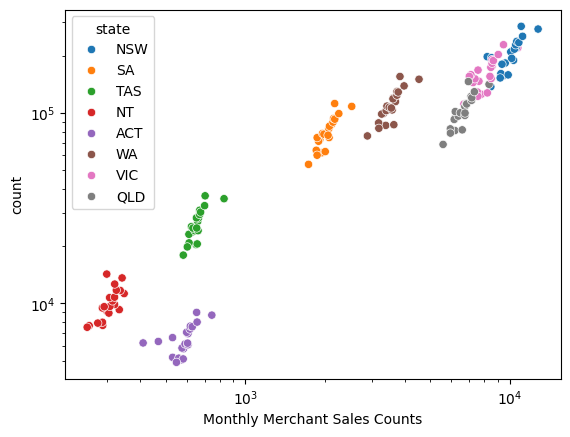

In [55]:
STATES = ["ACT", "NSW", "NT", "QLD", "SA", "TAS", "VIC", "WA"]
TREND_TYPE = "original"

retail_df = spark.read.parquet("../data/raw/retail_sales.parquet")
retail_df = retail_df.withColumn("month", F.month("date"))
retail_df = retail_df.withColumn("year", F.year("date"))
retail_df = retail_df.selectExpr("month", "year", "date", "stack({}, {}) as (state, sales)".format(
    len(STATES),
    ', '.join([f"'{col}', {col}_{TREND_TYPE}" for col in STATES])
))
# retail_df.show()

transactions_df = spark.read.parquet("../data/curated/full_transactions")
transactions_df = transactions_df.withColumn("month", F.month("order_datetime"))
transactions_df = transactions_df.withColumn("year", F.year("order_datetime"))
transactions_df = transactions_df.sort(F.col("order_datetime"))

transactions_df = transactions_df.where(F.col("state").isNotNull()) # TODO: How to resolve null state values?
transactions_df = transactions_df.groupBy("month", "year", "state").count()
transactions_df = transactions_df.withColumn("count", F.col("count").cast("double"))
# transactions_df.show()

# With imputing counts by the average sales per day
transactions_df = transactions_df.withColumn("count",
    F.when((F.col("month") == 2) & (F.col("year") == 2021), F.col("count") * 28.0) \
        .otherwise(F.col("count"))
)
transactions_df = transactions_df.withColumn("count",
    F.when((F.col("month") == 10) & (F.col("year") == 2022), F.col("count") * 31.0 / 26.0) \
        .otherwise(F.col("count"))
)

# Without imputing counts, just removing the earliest and latest month
# transactions_df = transactions_df.filter(
#     ~((F.col("month") == 2) & (F.col("year") == 2021)) &
#     ~((F.col("month") == 10) & (F.col("year") == 2022))
# )

joined_df = retail_df.join(transactions_df, on=['month', 'year', 'state'])
joined_df = joined_df.sort("year", "month")
joined_df.show()
sales_combined_df = joined_df.toPandas()
sns.scatterplot(sales_combined_df, x="sales", y="count", hue="state")
plt.xscale("log")
plt.xlabel("ABS Monthly Sales Turnover")
plt.yscale("log")
plt.xlabel("Monthly Merchant Sales Counts")

# results = smf.ols('count ~ Total_original', data=sales_combined_df).fit()
# print(results.summary())

+----+-----+--------------+--------+
|year|month|Total_original|   count|
+----+-----+--------------+--------+
|2021|    2|       26777.2|478996.0|
|2021|    3|       30336.0|546333.0|
|2021|    4|       29266.9|560680.0|
|2021|    5|       30216.8|636666.0|
|2021|    6|       29433.8|627148.0|
|2021|    7|       29172.7|655281.0|
|2021|    8|       28368.7|688829.0|
|2021|    9|       28901.7|678548.0|
|2021|   10|       31709.1|729648.0|
|2021|   11|       35171.1|991275.0|
|2021|   12|       40863.3|957703.0|
|2022|    1|       31862.0|552498.0|
|2022|    2|       29208.8|530793.0|
|2022|    3|       32830.9|657968.0|
|2022|    4|       32535.1|675032.0|
|2022|    5|       33287.1|762679.0|
|2022|    6|       33035.5|754184.0|
|2022|    7|       33800.0|791473.0|
|2022|    8|       33877.5|827144.0|
|2022|    9|       34276.8|817096.0|
+----+-----+--------------+--------+
only showing top 20 rows

                            OLS Regression Results                            
Dep. Va

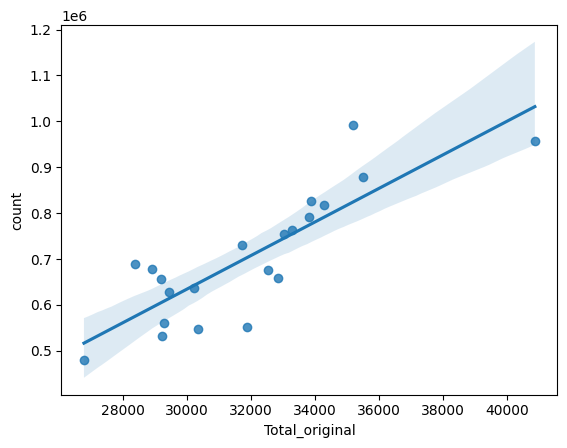

In [44]:
# Show total by month
retail_df = spark.read.parquet("../data/raw/retail_sales.parquet")
retail_df = retail_df.withColumn("month", F.month("date"))
retail_df = retail_df.withColumn("year", F.year("date"))

transactions_df = spark.read.parquet("../data/curated/full_transactions")
transactions_df = transactions_df.withColumn("month", F.month("order_datetime"))
transactions_df = transactions_df.withColumn("year", F.year("order_datetime"))
transactions_df = transactions_df.sort(F.col("order_datetime"))

transactions_df = transactions_df.groupBy("month", "year").count()
transactions_df = transactions_df.withColumn("count", F.col("count").cast("double"))

# With imputing counts by the average sales per day
transactions_df = transactions_df.withColumn("count",
    F.when((F.col("month") == 2) & (F.col("year") == 2021), F.col("count") * 28.0) \
        .otherwise(F.col("count"))
)
transactions_df = transactions_df.withColumn("count",
    F.when((F.col("month") == 10) & (F.col("year") == 2022), F.col("count") * 31.0 / 26.0) \
        .otherwise(F.col("count"))
)

# # Without imputing counts, just removing the earliest and latest month
# # transactions_df = transactions_df.filter(
# #     ~((F.col("month") == 2) & (F.col("year") == 2021)) &
# #     ~((F.col("month") == 10) & (F.col("year") == 2022))
# # )

joined_df = retail_df.join(transactions_df, on=['month', 'year'])
joined_df = joined_df.sort("year", "month")
joined_df = joined_df.select("year", "month", "Total_original", "count")
joined_df.show()
sales_combined_df = joined_df.toPandas()
sns.regplot(sales_combined_df, x="Total_original", y="count")

results = smf.ols('count ~ Total_original', data=sales_combined_df).fit()
print(results.summary())

In [64]:
# Show distribution of transaction dollar amounts
# TODO: Look at distribution in more detail, and see if there are any patterns with which merchants have which dollar amount ranges
transactions_df = spark.read.parquet("../data/curated/full_transactions")
transactions_df = transactions_df.where(F.col("dollar_value") < 1000)
sales_df = transactions_df.to_pandas_on_spark()

sales_df.loc[:, 'dollar_value'].plot.hist()

/Users/alanlu/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/documents/2024/MAST30034/proj2/project-2-group-buy-now-pay-later-industry-project-30/.venv/lib/python3.11/site-packages/pyspark/sql/dataframe.py:5725: FutureWarning:

DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.



24/09/08 21:57:50 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 6606750 ms exceeds timeout 120000 ms
24/09/08 21:57:50 WARN SparkContext: Killing executors is not supported by current scheduler.
24/09/08 21:57:50 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at 

In [6]:
# Joining transactions with ABS data
transactions_df = spark.read.parquet("../data/curated/full_transactions")
# transactions_df.show()

census_df = spark.read.parquet('../data/raw/census2021.parquet')
census_df = census_df.withColumnRenamed("POA_CODE_2021", "postcode")
# census_df.show()

transactions_df = transactions_df.join(census_df, on="postcode", how="left")
transactions_df.show()
transactions_df.write.mode("overwrite").parquet("../data/curated/full_transactions.parquet")

+--------+--------------+------------+-------+-----------+------------------+--------------------+-----------------+-----+-----------+-----------------+--------------------+--------------------+--------------------+-----+-----+--------------------------+------------------+-------------------------+-------------------------+----------------------+------+-------+------+
|postcode|order_datetime|merchant_abn|user_id|consumer_id|      dollar_value|            order_id|    consumer_name|state|     gender|fraud_probability|       merchant_name|                tags|               tags1|tags2|tags3|merchant_fraud_probability|Median_age_persons|Median_tot_fam_inc_weekly|Median_tot_hhd_inc_weekly|Average_household_size| Tot_M|  Tot_P| Tot_F|
+--------+--------------+------------+-------+-----------+------------------+--------------------+-----------------+-----+-----------+-----------------+--------------------+--------------------+--------------------+-----+-----+--------------------------+----